# Chapter 6. Decision Trees

Decision Trees are versatile Machine Learning algorithms similar to SVMs, capable of performing classification, regression, and multioutput tasks. They can handle complex datasets and are used as the foundation for powerful algorithms like Random Forests. 

The chapter covers various aspects of Decision Trees, including training, visualization, and prediction methods. It also delves into the CART training algorithm used by Scikit-Learn, regularization techniques, and regression applications. However, Decision Trees have limitations that will also be explored.

In [7]:
# Setup
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Training and Visualizing a Decision Tree

To understand Decision Trees, let’s build one and take a look at how it makes predictions.
The following code trains a DecisionTreeClassifier on the iris dataset (see Chapter 4):

In [8]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

This code example generates Figure 6–1. Iris Decision Tree:



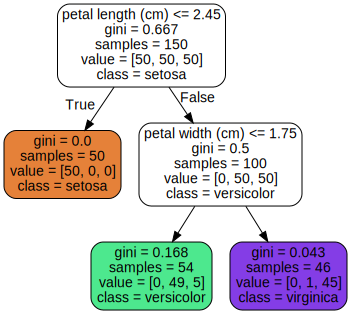

In [9]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

Then you can use the dot command-line tool from the Graphviz package to convert this .dot
file to a variety of formats, such as PDF or PNG. This command line converts the .dot file
to a .png image file:

In [11]:
!dot -Tpng images/decision_trees/iris_tree.dot -o images/decision_trees/iris_tree.png

### Making Predictions

In Figure 6-1, a Decision Tree is used to classify iris flowers based on their petal length and petal width. Starting at the root node, which checks if the petal length is smaller than 2.45 cm, the algorithm follows a series of questions to navigate through the tree. 

For a given flower, if the petal length is smaller than 2.45 cm, it predicts it as an Iris setosa. If the petal length is greater than 2.45 cm, the algorithm moves to the right child node and asks another question about the petal width. Depending on the petal width, it predicts the flower as either an Iris versicolor or an Iris virginica. The process is straightforward and leads to accurate classifications.

Code to generate Figure 6–2. Decision Tree decision boundaries



Saving figure decision_tree_decision_boundaries_plot


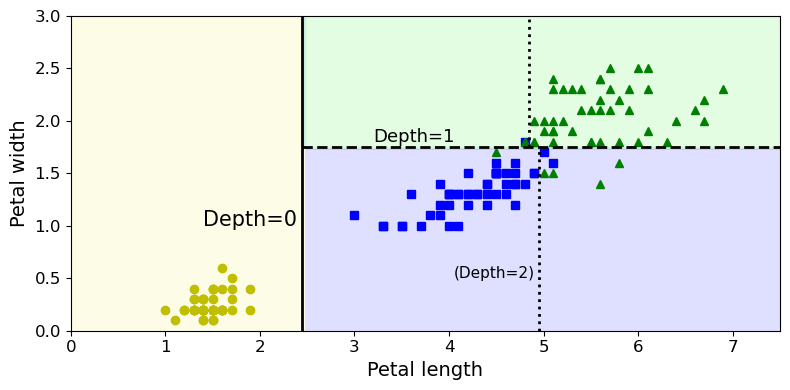

In [12]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

In Figure 6-2, the decision boundaries of a Decision Tree are visualized. The thick vertical line represents the root node's decision boundary, where petal length is 2.45 cm. The left area is pure and contains only Iris setosa, so it cannot be further split. However, the right area is impure and is split by the depth-1 right node at petal width = 1.75 cm (represented by the dashed line). The maximum depth of the tree is set to 2, resulting in the termination of the tree. If the max_depth were set to 3, two depth-2 nodes would add additional decision boundaries represented by dotted lines.

### Estimating Class Probabilities

A Decision Tree can estimate the probability that an instance belongs to a specific class by traversing the tree to find the corresponding leaf node and then returning the ratio of training instances of that class in the node. For instance, if a flower has petal lengths of 5 cm and a width of 1.5 cm, the Decision Tree would identify the depth-2 left node and output the probabilities as follows: 0% for Iris setosa (0/54), 90.7% for Iris versicolor (49/54), and 9.3% for Iris virginica (5/54). If asked to predict the class, it would output Iris versicolor (class 1) since it has the highest probability among the classes in that leaf node.

Let’s check this:

In [13]:
tree_clf.predict_proba([[5, 1.5]])


array([[0.        , 0.90740741, 0.09259259]])

In [14]:
tree_clf.predict([[5, 1.5]])


array([1])

The estimated probabilities remain the same throughout the bottom-right rectangle of Figure 6-2. For instance, if the flower's petal lengths were 6 cm and 1.5 cm wide, the probabilities would be identical to the previous case, despite it being more likely to be an Iris virginica in this scenario. This limitation of Decision Trees is due to their binary nature, where each leaf node predicts a single class, and they cannot represent probabilities accurately for regions with mixed instances.

### Regularization Hyperparameters